In [2]:
import glob
import pylab as pl
import numpy as np
import matplotlib
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import desimodel
import desimeter

from   matplotlib.patches import Ellipse
from   astropy.time import Time
from   astropy.table import Table, vstack, join
from   desimodel.focalplane.geometry import xy2radec 
from   desimodel.io import load_fiberpos 
from   desitarget.geomask import circles
from   desitarget.sv3.sv3_targetmask import desi_mask, bgs_mask, mws_mask
from   desimeter.fiberassign import fiberassign_flat_xy2radec, radec2tan
from   fiberassign.hardware import xy2radec
from   fiberassign.hardware import load_hardware

In [3]:
def tile2rosette(tile):
    if tile < 433:
        return (tile-1)//27
    else:
        if tile >= 433 and tile < 436:
            return 13
        if tile >= 436 and tile < 439:
            return 14
        if tile >= 439 and tile < 442:
            return 15
        if tile >= 442 and tile <=480:
            return (tile-442)//3
            
        if tile > 480:
            return tile//30    
    return 999999 #shouldn't be any more?

In [4]:
tiles = Table.read('/global/cscratch1/sd/mjwilson/S4MOCK/tiles-sv3.ecsv')
tiles = tiles[(tiles['STATUS'] == 'done') & (tiles['PROGRAM']=='BRIGHT')]
tiles['ROSETTE'] = np.array([tile2rosette(x) for x in tiles['TILEID']])
tiles

TILEID,PASS,RA,DEC,PROGRAM,IN_DESI,PRIORITY,STATUS,EBV_MED,DESIGNHA,DONEFRAC,AVAILABLE,ROSETTE
int64,int32,float64,float64,str6,bool,float64,str8,float32,float32,float32,bool,int64
12,0,150.04,2.286,BRIGHT,True,0.000e+00,done,0.022782475,0.00,1.0455,False,0
13,1,150.061,2.069,BRIGHT,True,0.000e+00,done,0.023243327,0.00,1.1505,False,0
14,2,150.212,2.226,BRIGHT,True,0.000e+00,done,0.022683823,0.00,1.0456,False,0
15,3,149.98,2.171,BRIGHT,True,0.000e+00,done,0.023039486,0.00,1.1052,False,0
16,4,150.187,2.099,BRIGHT,True,0.000e+00,done,0.023041949,0.00,1.0776,False,0
17,5,150.106,2.302,BRIGHT,True,0.000e+00,done,0.022638734,0.00,1.1865,False,0
18,6,149.993,2.237,BRIGHT,True,0.000e+00,done,0.022844847,0.00,1.4589,False,0
19,7,150.128,2.065,BRIGHT,True,0.000e+00,done,0.023041053,0.00,1.3565,False,0
20,8,150.17,2.28,BRIGHT,True,0.000e+00,done,0.02263027,0.00,1.1368,False,0


In [5]:
np.unique(tiles['ROSETTE'].data)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [6]:
cmap = matplotlib.cm.get_cmap("magma", 20)

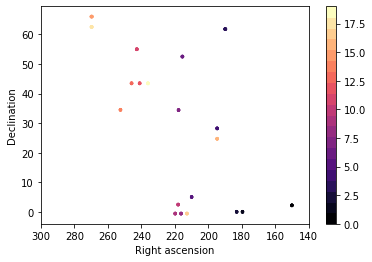

In [7]:
pl.scatter(tiles['RA'], tiles['DEC'], marker='.', lw=0.0, c=tiles['ROSETTE'], cmap=cmap)
pl.xlim(300., 140.)
pl.xlabel('Right ascension')
pl.ylabel('Declination')
pl.colorbar()

In [8]:
# glob.glob('/global/cscratch1/sd/mjwilson/S4MOCK/SV3REAL/SV3REALLEDGER/bright/*')

In [9]:
ledger = vstack([Table.read(x) for x in glob.glob('/global/cscratch1/sd/mjwilson/S4MOCK/SV3REAL/SV3REALLEDGER/bright/*')])

In [10]:
np.mean(ledger['PRIORITY_INIT'] == ledger['PRIORITY'])

0.6553668048332207

In [11]:
ledger    = ledger[ledger['PRIORITY_INIT'] == ledger['PRIORITY']]

In [12]:
len(ledger) / 1.e6

1.448765

In [13]:
tids      = tiles['TILEID'].data[tiles['ROSETTE'] == 15]
tids

array([417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427])

In [14]:
root      = '/global/cscratch1/sd/mjwilson/S4MOCK/SV3REAL/SV3REALASSIGN/'

In [15]:
nights    = [x.split('/')[-1] for x in sorted(glob.glob(root + '/*'))]
nights.remove('SV3.ecsv')
nights

['20210405',
 '20210407',
 '20210408',
 '20210409',
 '20210410',
 '20210411',
 '20210412',
 '20210413',
 '20210414',
 '20210415',
 '20210416',
 '20210417',
 '20210418',
 '20210419',
 '20210420',
 '20210422',
 '20210429',
 '20210430',
 '20210501',
 '20210502',
 '20210503',
 '20210504',
 '20210505',
 '20210506',
 '20210507',
 '20210508',
 '20210509',
 '20210510',
 '20210511',
 '20210512',
 '20210513',
 '20210514',
 '20210518',
 '20210521',
 '20210529']

In [16]:
fp            = load_fiberpos() 

In [17]:
patrol_radii  = 1.48/60. # degrees 

In [18]:
tile_radii    = desimodel.focalplane.geometry.get_tile_radius_deg()
tile_radii

1.6280324520485583

In [19]:
def radec2standard(ra, dec, tile_ra, tile_dec):
    # https://phys.libretexts.org/Bookshelves/Astronomy__Cosmology/Book%3A_Celestial_Mechanics_(Tatum)/11%3A_Photographic_Astrometry/11.02%3A_Standard_Coordinates_and_Plate_Constants
    _ra       = np.radians(ra)
    _dec      = np.radians(dec)
    _tra      = np.radians(tile_ra)
    _tdec     = np.radians(tile_dec)
    
    xi        = np.sin(_ra - _tra) / (np.sin(_tdec) * np.tan(_dec) + np.cos(_tdec) * np.cos(_ra - _tra))
    eta       = (np.tan(_dec) - np.tan(_tdec) * np.cos(_ra - _tra)) / (np.tan(_tdec) * np.tan(_dec) + np.cos(_ra - _tra)) 
    
    return xi, eta

In [20]:
rundate        = '2019-03-17T23:20:01' 
rundate        = '2021-03-17T23:20:01'

hw             = load_hardware(rundate=rundate)

xys            = np.array(list(hw.loc_pos_cs5_mm.values()))

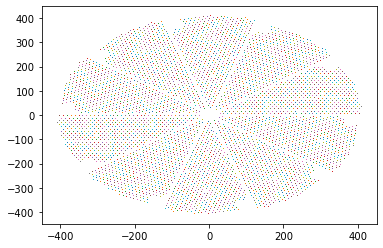

In [21]:
for x, y in xys:
    pl.plot(x, y, marker=',', lw=0.0)

In [21]:
tra            = 55.0
tdec           = 30.0

tt             = Time('2021-03-17T23:20:01', format='isot', scale='utc')

mjd            = 59290.972233796296
fieldrot       = -0.307551638980923
lst_deg        = tra

M1_focallength = 10.7

ras            = np.random.uniform(45., 65., 100)
decs           = np.random.uniform(25., 35., 100)

xis, etas      = radec2standard(ras, decs, tra, tdec)

# pl.plot(xis, etas, marker='.', lw=0.0, markersize=2)

# https://github.com/desihub/desimeter/blob/e575f22c8820d4f98a6715ad7574130a6d11b09b/py/desimeter/transform/radec2tan.py#L386
desi_xis, desi_etas = radec2tan(ras, decs, tra, tdec, mjd, lst_deg, fieldrot, precession=False, aberration=False, polar_misalignment=False, use_astropy=False) 

# pl.plot(-desi_xis, desi_etas, marker='.', lw=0.0, markersize=2)

# pl.xlabel(r'$\xi$ [F]')
# pl.ylabel(r'$\eta$ [F]')

In [24]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

20210405 [417]
/global/cscratch1/sd/mjwilson/S4MOCK/SV3REAL/SV3REALASSIGN//20210405/fba-000417.fits


Requested fieldrot=-1107.2 arcsec delta=-0.0 arcsec
Requested fieldrot=-1107.2 arcsec delta=-0.0 arcsec
Requested fieldrot=-1107.2 arcsec delta=-0.0 arcsec
Requested fieldrot=-1107.2 arcsec delta=-0.0 arcsec


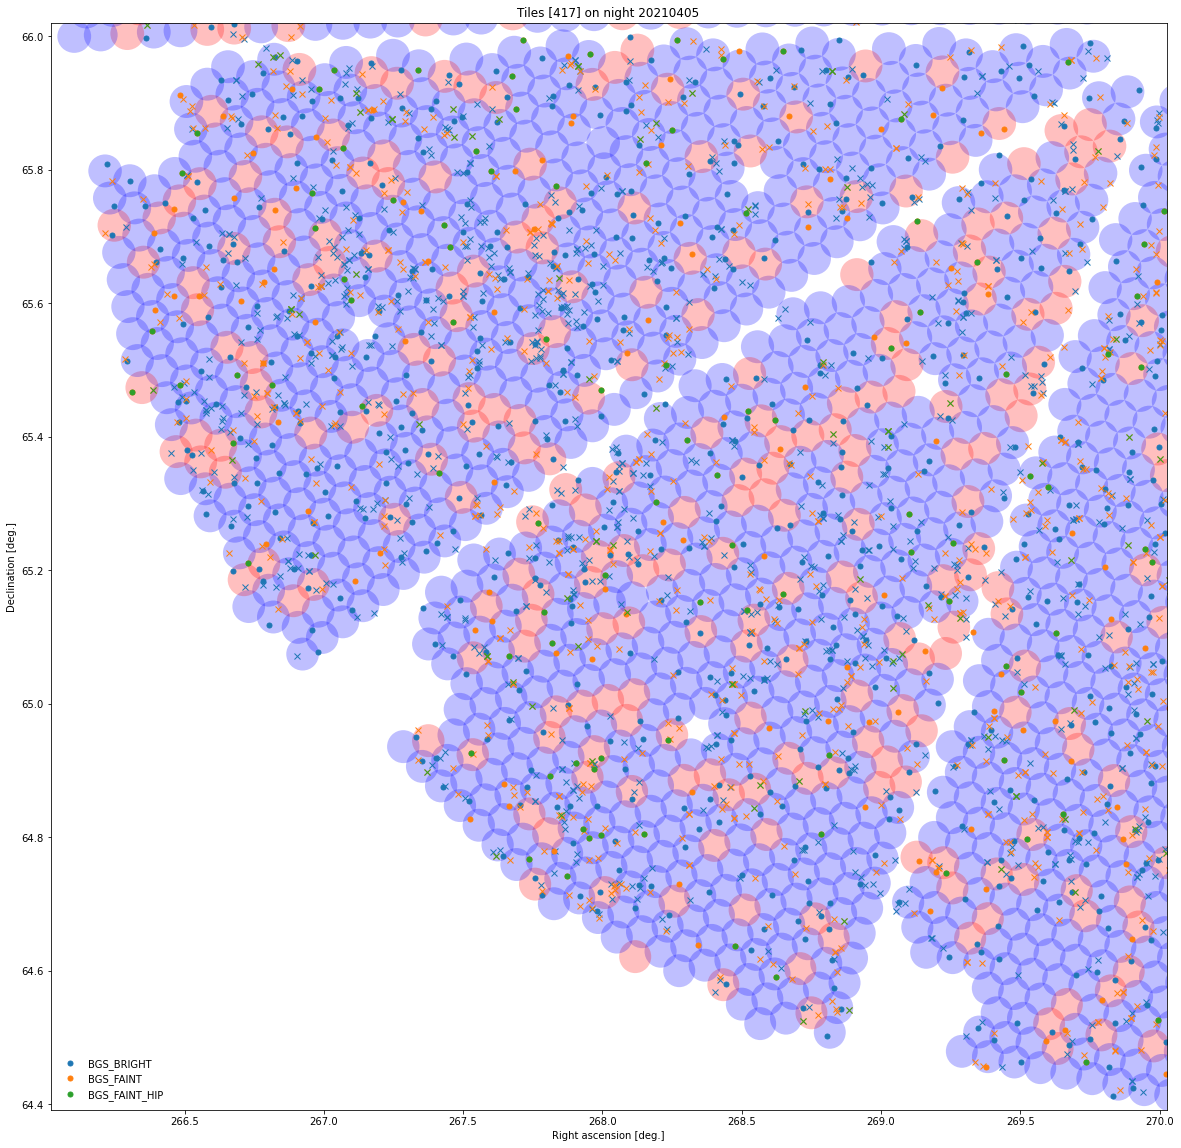

<Figure size 432x288 with 0 Axes>

In [138]:
for night in nights:
    fbas      = sorted(glob.glob(root + '/' + night + '/fba-*.fits'))
    ts        = np.array([x.split('/')[-1].replace('.fits','').replace('fba-','') for x in fbas]).astype(np.int64)
    
    ts        = ts[np.isin(ts, tids)]
    
    print(night, ts)
    
    if len(ts) == 0:
        continue

    fig, axes = plt.subplots(len(ts), 1, figsize=(20*len(ts),20))

    if len(ts) == 1:
        axes  = np.array([axes])

    for i, tid in enumerate(ts):
        fpath    = root + '/' + night + '/fba-{:06d}.fits'.format(tid)
        tpath    = root + '/' + night + '/{:06d}-targ.fits'.format(tid)

        print(fpath)
        
        hdr      = fits.open(fpath)[1].header
        
        tra      = hdr['TILERA']                                                  
        tdec     = hdr['TILEDEC']                                           
        fieldrot = hdr['FIELDROT']                                                
        fa_plan  = hdr['FA_PLAN']
        fa_run   = hdr['FA_RUN']
        fa_ha    = hdr['FA_HA']                                                           

        hw       = load_hardware(rundate=fa_run)
        
        tt       = Time(fa_run, format='isot', scale='utc')
        fba_mjd  = tt.mjd 
        
        tra      = fits.open(fpath)[1].header['TILERA']
        tdec     = fits.open(fpath)[1].header['TILEDEC']
                
        targ  = Table.read(tpath)
        fba   = Table.read(fpath, hdu='FASSIGN')
        ftarg = Table.read(fpath, hdu='FTARGETS')
        favl  = Table.read(fpath, hdu='FAVAIL')
    
        # 
        fba   = fba[fba['FIBERSTATUS'] == 0]
        
    
        
        
        # remove skies
        fba   = fba[(fba['FA_TYPE'].data & 4) == 0]
        
        
        
        # Only keep targets available to a good fiber. 
        bavl  = favl[~np.isin(favl['LOCATION'], fba['LOCATION'].data)] 
        favl  = favl[ np.isin(favl['LOCATION'], fba['LOCATION'].data)] 
    
        favl  = join(favl, ledger, keys='TARGETID', join_type='left')
        fba   = join(fba,  ledger, keys='TARGETID', join_type='left')
        
        glocs = fba['LOCATION']
        
        # Keep only the matches.
        favl  = favl[~favl['RA'].mask]
        
        # Keep only the matches.
        fba   = fba[~fba['RA'].mask]
        
        

        # Keep available only if unassigned.
        favl  = favl[~np.isin(favl['TARGETID'].data, fba['TARGETID'])]
                        
        # ra, dec = xy2radec(tra, tdec, fp["X"], fp["Y"])

        # assumes x,y are flat focal plane coordinates
        # ras, decs = fiberassign_flat_xy2radec(fp['X'], fp['Y'], tra, tdec, fba_mjd, fa_ha, fieldrot, from_platemaker=False)
        
        ras, decs = xy2radec(hw, tra, tdec, tt, fieldrot, fa_ha, xys[:,0], xys[:,1], use_cs5=True)
    
        # https://github.com/desihub/fiberassign/blob/a3abb8758ddff19f7d256885ad4dfa83f787bd7f/py/fiberassign/hardware.py#L408
        # xy2radec(hw, tile_ra, tile_dec, tile_obstime, tile_obstheta, tile_obsha, x, y, use_cs5, threads=0)
    
        # https://en.wikipedia.org/wiki/Angular_distance
        #
        # At fixed dec, change in ra for patrol radii is:
        patrol_dra = patrol_radii / np.cos(np.radians(decs))
        
        # At fixed ra, change in dec for patrol radii is:
        patrol_ddec = patrol_radii
        
        glocs = np.isin(fp['LOCATION'], glocs)
        
        ells = []
        
        for ecount, (ra, dec, gloc) in enumerate(zip(ras, decs, glocs)):
            ells.append(Ellipse(xy=(ra, dec),
                        width=2. * patrol_dra[ecount], height=2. * patrol_ddec,
                        angle=0.0))
        
        for k, e in enumerate(ells):
            axes[i].add_artist(e)
            
            e.set_clip_box(axes[i].bbox)
            e.set_alpha(0.25)

            if glocs[k]:
                e.set_facecolor('b')

            else:
                e.set_facecolor('r')
        
        for j, ttype in enumerate(['BGS_BRIGHT', 'BGS_FAINT', 'BGS_FAINT_HIP']):
            # Keep only BGS Bright.
            _fba   =  fba[(fba['SV3_BGS_TARGET'].data  & bgs_mask[ttype]) != 0] 
            _favl  = favl[(favl['SV3_BGS_TARGET'].data & bgs_mask[ttype]) != 0] 
            

            # Plot targets available to a good fiber.
            # Note: limited to BGS Bright, and only if unassigned.  
            axes[i].plot(_favl['RA'].data, _favl['DEC'].data, marker='x', lw=0.0, markersize=6, alpha=1., c=colors[j])

            # Plot targets assigned to a good fiber.
            # axes[i].plot(_fba['TARGET_RA'].data, _fba['TARGET_DEC'].data, marker='*', lw=0.0, markersize=6, label=ttype)
            
            ras, decs = xy2radec(hw, tra, tdec, tt, fieldrot, fa_ha, _fba['FIBERASSIGN_X'], _fba['FIBERASSIGN_Y'], use_cs5=False)
            
            axes[i].plot(ras, decs, marker='.', lw=0.0, markersize=10, label=ttype, c=colors[j])
            
        left=tra-tile_radii / np.cos(np.radians(tdec))
        bottom=tdec-tile_radii
            
        axes[i].set_xlim(right=tra, left=left)
        axes[i].set_ylim(top=tdec, bottom=bottom)

        break
            
    pl.xlabel('Right ascension [deg.]')
    pl.ylabel('Declination [deg.]')        
    pl.legend(frameon=False, loc=3)
    pl.title('Tiles {} on night {}'.format(ts, night))
    pl.show()
    pl.clf()
    
    break

# The plot above is the one you originally sent me.  The one below is adding for skies and secondaries.  

20210405 [417]
/global/cscratch1/sd/mjwilson/S4MOCK/SV3REAL/SV3REALASSIGN//20210405/fba-000417.fits


Requested fieldrot=-1107.2 arcsec delta=-0.0 arcsec
0.0606
2407
2782
Requested fieldrot=-1107.2 arcsec delta=-0.0 arcsec
836
2675
Requested fieldrot=-1107.2 arcsec delta=-0.0 arcsec
336
370
Requested fieldrot=-1107.2 arcsec delta=-0.0 arcsec
303
Requested fieldrot=-1107.2 arcsec delta=-0.0 arcsec
303


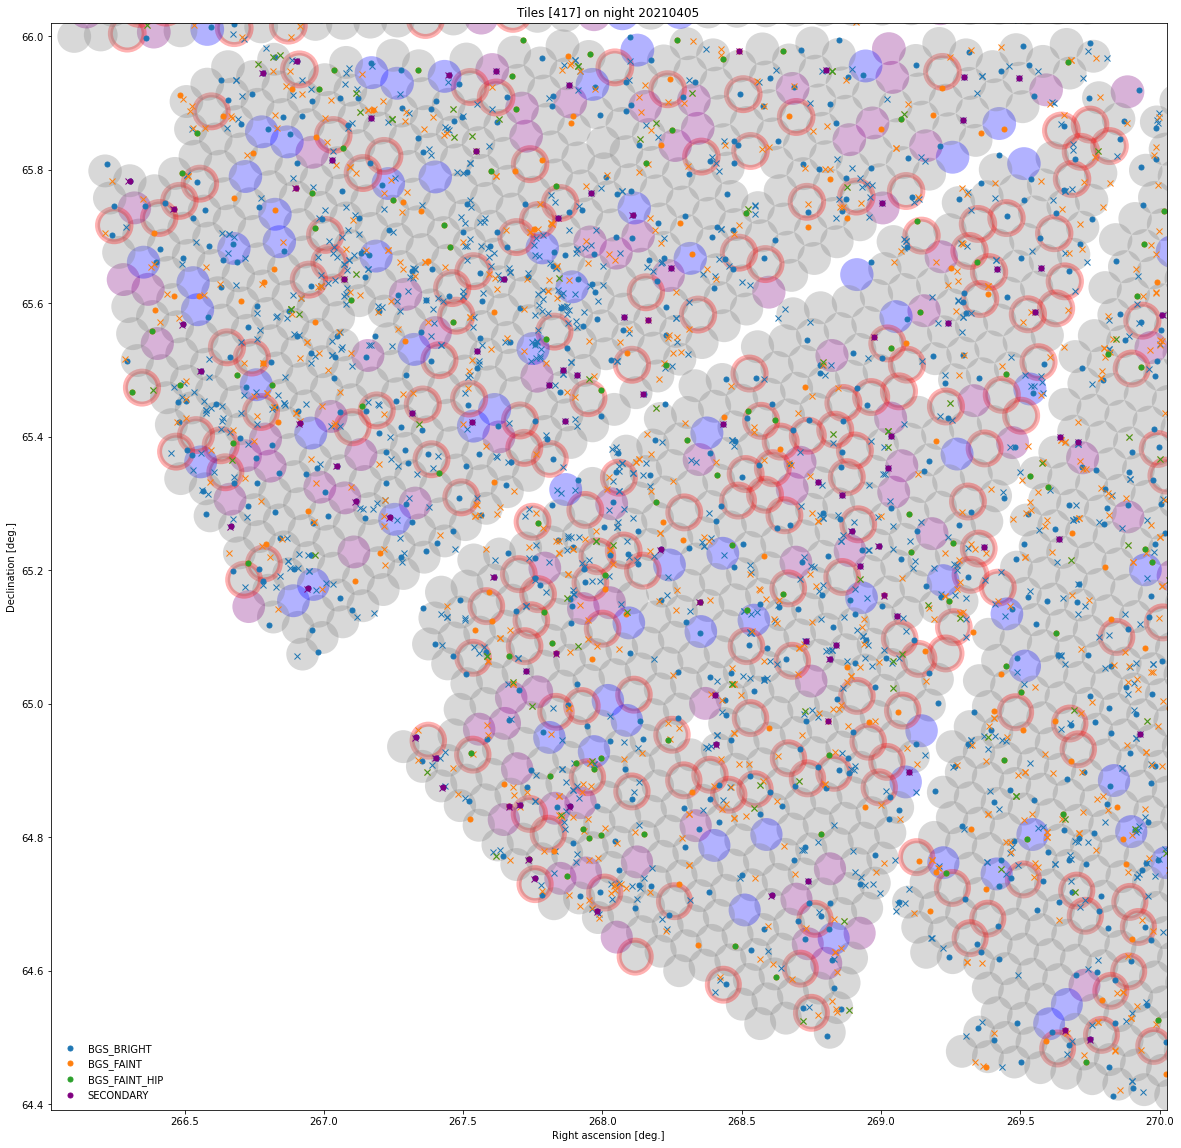

<Figure size 432x288 with 0 Axes>

In [51]:
for night in nights:
    fbas      = sorted(glob.glob(root + '/' + night + '/fba-*.fits'))
    ts        = np.array([x.split('/')[-1].replace('.fits','').replace('fba-','') for x in fbas]).astype(np.int64)
    
    ts        = ts[np.isin(ts, tids)]
    
    print(night, ts)
    
    if len(ts) == 0:
        continue

    fig, axes = plt.subplots(len(ts), 1, figsize=(20*len(ts),20))

    if len(ts) == 1:
        axes  = np.array([axes])

    for i, tid in enumerate(ts):
        fpath    = root + '/' + night + '/fba-{:06d}.fits'.format(tid)
        tpath    = root + '/' + night + '/{:06d}-targ.fits'.format(tid)

        print(fpath)
        
        hdr      = fits.open(fpath)[1].header
        
        tra      = hdr['TILERA']                                                  
        tdec     = hdr['TILEDEC']                                           
        fieldrot = hdr['FIELDROT']                                                
        fa_plan  = hdr['FA_PLAN']
        fa_run   = hdr['FA_RUN']
        fa_ha    = hdr['FA_HA']                                                           

        hw       = load_hardware(rundate=fa_run)
        
        tt       = Time(fa_run, format='isot', scale='utc')
        fba_mjd  = tt.mjd 
        
        tra      = fits.open(fpath)[1].header['TILERA']
        tdec     = fits.open(fpath)[1].header['TILEDEC']
                
        targ  = Table.read(tpath)
        fba   = Table.read(fpath, hdu='FASSIGN')
        ftarg = Table.read(fpath, hdu='FTARGETS')
        favl  = Table.read(fpath, hdu='FAVAIL')
    
        
        
        
        fba   = fba[fba['FIBERSTATUS'] == 0]
        
        
        sky = fba[(fba['FA_TYPE']==4)]
        
        #Get rid of skies.  Why doesnt it work if we do sky = fba[(fba['FA_TYPE'].data==1)], where 1 corrosponds to science targets?
        fba   = fba[(fba['FA_TYPE'].data & 4) == 0]
        
        
        # Only keep targets available to a good fiber. 
        bavl  = favl[~np.isin(favl['LOCATION'], fba['LOCATION'].data)] 
        favl  = favl[ np.isin(favl['LOCATION'], fba['LOCATION'].data)] 
    
        favl  = join(favl, ledger, keys='TARGETID', join_type='left')
        fba   = join(fba,  ledger, keys='TARGETID', join_type='left')
        
        
        glocs = fba['LOCATION']
        sky = sky['LOCATION']
        
        #have to do this after joining because then the sv3_bgs_target column is there 
        #x = fba[(fba['SV3_BGS_TARGET'].data) != 0] 
        x = fba[(fba["SV3_DESI_TARGET"] & desi_mask["BGS_ANY"]) != 0]
        secondary = x[(x['SV3_SCND_TARGET'].data>0)]
        
        secondary = secondary['LOCATION']
        
        
        # Keep only the matches.
        favl  = favl[~favl['RA'].mask]
        
        # Keep only the matches.
        fba   = fba[~fba['RA'].mask]
        
        

        # Keep available only if unassigned.
        favl  = favl[~np.isin(favl['TARGETID'].data, fba['TARGETID'])]
                        
        # ra, dec = xy2radec(tra, tdec, fp["X"], fp["Y"])

        # assumes x,y are flat focal plane coordinates
        # ras, decs = fiberassign_flat_xy2radec(fp['X'], fp['Y'], tra, tdec, fba_mjd, fa_ha, fieldrot, from_platemaker=False)
        
        ras, decs = xy2radec(hw, tra, tdec, tt, fieldrot, fa_ha, xys[:,0], xys[:,1], use_cs5=True)
    
        # https://github.com/desihub/fiberassign/blob/a3abb8758ddff19f7d256885ad4dfa83f787bd7f/py/fiberassign/hardware.py#L408
        # xy2radec(hw, tile_ra, tile_dec, tile_obstime, tile_obstheta, tile_obsha, x, y, use_cs5, threads=0)
    
        # https://en.wikipedia.org/wiki/Angular_distance
        #
        # At fixed dec, change in ra for patrol radii is:
        patrol_dra = patrol_radii / np.cos(np.radians(decs))
        
        # At fixed ra, change in dec for patrol radii is:
        patrol_ddec = patrol_radii
        
        glocs = np.isin(fp['LOCATION'], glocs)
        sky = np.isin(fp['LOCATION'],sky)
        secondary = np.isin(fp['LOCATION'],secondary)
        print(np.mean(secondary))
        
        ells = []
        
        for ecount, (ra, dec, gloc) in enumerate(zip(ras, decs, glocs)):
            ells.append(Ellipse(xy=(ra, dec),
                        width=2. * patrol_dra[ecount], height=2. * patrol_ddec,
                        angle=0.0))
        
        for k, e in enumerate(ells):
            axes[i].add_artist(e)
            
            e.set_clip_box(axes[i].bbox)
            e.set_alpha(0.3)

            if secondary[k]:
                e.set_facecolor('purple')
            
            elif glocs[k]:
                e.set_facecolor('gray')

            elif sky[k]:
                e.set_facecolor('blue')
                  
            
            else:
                e.set_edgecolor('r')
                e.set_facecolor('gray')
                e.set_linewidth(5)
                
        
        #this plots the actual targets 
        for j, ttype in enumerate(['BGS_BRIGHT', 'BGS_FAINT', 'BGS_FAINT_HIP']):
            # Keep only BGS Bright.
            _fba   =  fba[(fba['SV3_BGS_TARGET'].data  & bgs_mask[ttype]) != 0] 
            _favl  = favl[(favl['SV3_BGS_TARGET'].data & bgs_mask[ttype]) != 0] 
            

            # Plot targets available to a good fiber.
            # Note: limited to BGS Bright, and only if unassigned.  
            axes[i].plot(_favl['RA'].data, _favl['DEC'].data, marker='x', lw=0.0, markersize=6, alpha=1., c=colors[j])
            print(len(_fba))
            print(len(_favl))
            # Plot targets assigned to a good fiber.
            #axes[i].plot(_fba['TARGET_RA'].data, _fba['TARGET_DEC'].data, marker='.', lw=0.0, markersize=10, label=ttype, c=colors[j])
            
            
            #pretty sure above does same thing so why go to the effort of doing this 
            ras, decs = xy2radec(hw, tra, tdec, tt, fieldrot, fa_ha, _fba['FIBERASSIGN_X'], _fba['FIBERASSIGN_Y'], use_cs5=False)
            
            axes[i].plot(ras, decs, marker='.', lw=0.0, markersize=10, label=ttype, c=colors[j])
            
        
        _x = fba[(fba["SV3_DESI_TARGET"] & desi_mask["BGS_ANY"]) != 0]
        secondary_fba = _x[(_x['SV3_SCND_TARGET'].data>0)]
        print(len(secondary_fba))
        
        ras, decs = xy2radec(hw, tra, tdec, tt, fieldrot, fa_ha, secondary_fba['FIBERASSIGN_X'], secondary_fba['FIBERASSIGN_Y'], use_cs5=False)
        axes[i].plot(ras, decs, marker='.', lw=0.0, markersize=10, label='SECONDARY', c='purple')
        
        _x = fba[(fba["SV3_DESI_TARGET"] & desi_mask["BGS_ANY"]) != 0]
        secondary_favl = _x[(_x['SV3_SCND_TARGET'].data>0)]
        print(len(secondary_favl))
        axes[i].plot(secondary_favl['RA'].data,secondary_favl['DEC'].data, marker='x', lw=0.0, markersize=6, alpha=1., c='purple')
        
        
        
        left=tra-tile_radii / np.cos(np.radians(tdec))
        bottom=tdec-tile_radii
            
        axes[i].set_xlim(right=tra, left=left)
        axes[i].set_ylim(top=tdec, bottom=bottom)

        break
            
    
    pl.xlabel('Right ascension [deg.]')
    pl.ylabel('Declination [deg.]')        
    pl.legend(frameon=False, loc=3)
    pl.title('Tiles {} on night {}'.format(ts, night))
    pl.show()
    pl.clf()
    
    break


In [154]:
#This was me checking that positions of fibers and targets matched up as they should, etc, all seems fine 

ras = []
decs = []
ra = []
dec = []

for i in range(len(_fba)):
    x = fp[(fp['FIBER']==_fba['FIBER'].data[i])]
    r, d = xy2radec(hw, tra, tdec, tt, fieldrot, fa_ha, x['X'],x['Y'], use_cs5=False)
    ras.append(r)
    decs.append(d)
    
    r1, d1 = _fba['RA'].data[i],_fba['DEC'].data[i]
    ra.append(r1)
    dec.append(d1)

diff_ra= []
for i in range(len(ras)):
    diff_ra.append(ras[i]-ra[i])

diff_ra = np.concatenate(np.array(diff_ra)) 

diff_dec= []
for i in range(len(ras)):
    diff_dec.append(decs[i]-dec[i])
    
diff_dec = np.concatenate(np.array(diff_dec))  

patrol_dra = []
for i in range(len(decs)):
    patrol_dra.append(patrol_radii / np.cos(np.radians(decs[i])))

patrol_dra = np.concatenate(np.array(patrol_dra))
    
is_in_radius = []
for i in range(len(diff_ra)):
    if (patrol_dra[i]<np.abs(diff_ra[i])):
        is_in_radius.append('y')
print(is_in_radius)

plt.hist(diff_ra)
plt.hist(diff_dec)

0.004